# bert ner conll2003

Import required python packages including pytorch, transformers, and seqeval for performance evaluation on Google Colab.

In [1]:
!pip3 install transformers

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 71.3 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 895 kB 65.3 MB/s 
     |████████████████████████████████| 3.3 MB 53.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')
! ls /content/drive/My\ Drive/

Mounted at /content/drive
'79_LAKHAL ADNANE_Geoeconomie recherche.pdf'
'Alfresco Working Directory'
 bert_ner.pt
'BitCoin Dataset.csv'
'bitcoin data visualisation LAKHAL ADNANE.html'
 Classroom
'Colab Notebooks'
'Copie de SQL Project Submission Template (make a copy) - Graphique à barres 1 (1).gsheet'
'Copie de SQL Project Submission Template (make a copy) - Graphique à barres 1 (2).gsheet'
'Copie de SQL Project Submission Template (make a copy) - Graphique à barres 1 (3).gsheet'
'Copie de SQL Project Submission Template (make a copy) - Graphique à barres 1.gsheet'
'Copie de SQL Project Submission Template (make a copy) - Graphique à colonnes 1 (1).gsheet'
'Copie de SQL Project Submission Template (make a copy) - Graphique à colonnes 1 (2).gsheet'
'Copie de SQL Project Submission Template (make a copy) - Graphique à colonnes 1 (3).gsheet'
'Copie de SQL Project Submission Template (make a copy) - Graphique à colonnes 1.gsheet'
'Copie de SQL Project Submission Template (make a co

In [3]:
!pip3 install seqeval

     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=d581ec74646a3bcab64ed6c360beaecb02750a5da7688af7caad759a2e290090
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [4]:
import os
import time
import numpy as np
from tqdm import tqdm, trange
import codecs
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

print(transformers.__version__)
print(torch.__version__)

4.15.0
1.10.0+cu111


Set the path of dataset.

In [5]:
data_path = '/content/drive/My Drive/data/'

fnames = os.listdir(data_path)
fnames.sort()
print(fnames)

data_files = []
for f in fnames:
    data_files.append(os.path.join(data_path, f))
print(data_files)

['dev.txt', 'test.txt', 'train.txt']
['/content/drive/My Drive/data/dev.txt', '/content/drive/My Drive/data/test.txt', '/content/drive/My Drive/data/train.txt']


In [6]:
word_count = {}
tag_count = {}
word_train = []
train_tag = []
word_val = []
val_tag = []
word_test = []
test_tag = []
corpus_dic = {'word_test': word_test, 'test_tag': test_tag, 
              'word_val': word_val, 'val_tag': val_tag, 
              'word_train': word_train, 'train_tag': train_tag}
corpus_list = ['word_test', 'test_tag', 'word_train', 
               'train_tag', 'word_val', 'val_tag']
corpus_dic

{'test_tag': [],
 'train_tag': [],
 'val_tag': [],
 'word_test': [],
 'word_train': [],
 'word_val': []}

Import three datasets

In [7]:
for i, f in enumerate(data_files):
    with codecs.open(f, encoding='utf-8') as fid:
        for l in fid:
            if l == '\r\n' or l == '\n': continue
                
            l = l.replace('\r\n', '')
            t = l.split()
            corpus_dic[corpus_list[2*i]].append(t[0])
            corpus_dic[corpus_list[2*i+1]].append(t[1])

In [8]:
for i in range(len(data_files)):
    for w in corpus_dic[corpus_list[2*i]]:
        if w in word_count:
            word_count[w] += 1
        else:
            word_count[w] = 1
    
    for t in corpus_dic[corpus_list[2*i+1]]:
        if t in tag_count:
            tag_count[t] += 1
        else:
            tag_count[t] = 1

In [9]:
tag_count
#print(word_count)

{'"': 3239,
 '$': 622,
 "''": 60,
 '(': 4233,
 ')': 4232,
 ',': 10877,
 '.': 10898,
 ':': 3609,
 'CC': 5350,
 'CD': 29962,
 'DT': 19773,
 'EX': 210,
 'FW': 228,
 'IN': 28059,
 'JJ': 17267,
 'JJR': 579,
 'JJS': 388,
 'LS': 37,
 'MD': 1767,
 'NN': 34856,
 'NNP': 51545,
 'NNPS': 1010,
 'NNS': 14580,
 'NN|SYM': 5,
 'PDT': 47,
 'POS': 2323,
 'PRP': 4630,
 'PRP$': 2238,
 'RB': 5852,
 'RBR': 259,
 'RBS': 62,
 'RP': 784,
 'SYM': 642,
 'TO': 5193,
 'UH': 42,
 'VB': 6304,
 'VBD': 12222,
 'VBG': 3769,
 'VBN': 5964,
 'VBP': 2132,
 'VBZ': 3439,
 'WDT': 769,
 'WP': 769,
 'WP$': 41,
 'WRB': 551}

In [17]:
print(tag_count.values)

<built-in method values of dict object at 0x7f6cdff83050>


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

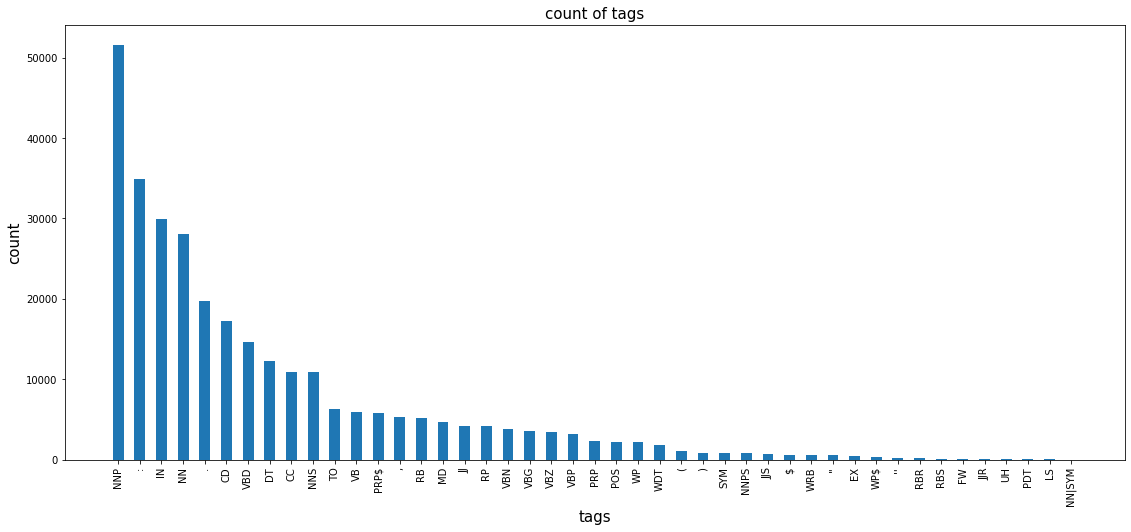

In [36]:
plt.figure(figsize=[19, 8])
plt.bar(tag_count.keys(), sorted(tag_count.values(),reverse = True), width=0.5)

plt.title('count of tags', fontsize=15)
plt.xlabel('tags', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [30]:
wcounts = list(word_count.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
word_sorted = [w[0] for w in wcounts]
word_index = dict(list(zip(word_sorted, list(range(1, len(word_count) + 1)))))
word_index['PAD'] = 0
word_index['UNK'] = len(word_index)

Generate a dictionary of tags

In [31]:
tag_index = {t[0]: i for i, t in enumerate(list(tag_count.items()))}
index_tag = {i: t[0] for i, t in enumerate(list(tag_count.items()))}

Insert PAD label into the dictionary.

In [32]:
tag_index['PAD'] = len(tag_count)
index_tag[len(tag_count)] = 'PAD'

In [33]:
index_tag

{0: 'NNP',
 1: ':',
 2: 'IN',
 3: 'NN',
 4: '.',
 5: 'CD',
 6: 'VBD',
 7: 'DT',
 8: 'CC',
 9: 'NNS',
 10: 'TO',
 11: 'VB',
 12: 'PRP$',
 13: ',',
 14: 'RB',
 15: 'MD',
 16: 'JJ',
 17: 'RP',
 18: 'VBN',
 19: 'VBG',
 20: 'VBZ',
 21: 'VBP',
 22: 'PRP',
 23: 'POS',
 24: 'WP',
 25: 'WDT',
 26: '(',
 27: ')',
 28: 'SYM',
 29: 'NNPS',
 30: 'JJS',
 31: '$',
 32: 'WRB',
 33: '"',
 34: 'EX',
 35: 'WP$',
 36: "''",
 37: 'RBR',
 38: 'RBS',
 39: 'FW',
 40: 'JJR',
 41: 'UH',
 42: 'PDT',
 43: 'LS',
 44: 'NN|SYM',
 45: 'PAD'}

In [34]:
tag_index

{'"': 33,
 '$': 31,
 "''": 36,
 '(': 26,
 ')': 27,
 ',': 13,
 '.': 4,
 ':': 1,
 'CC': 8,
 'CD': 5,
 'DT': 7,
 'EX': 34,
 'FW': 39,
 'IN': 2,
 'JJ': 16,
 'JJR': 40,
 'JJS': 30,
 'LS': 43,
 'MD': 15,
 'NN': 3,
 'NNP': 0,
 'NNPS': 29,
 'NNS': 9,
 'NN|SYM': 44,
 'PAD': 45,
 'PDT': 42,
 'POS': 23,
 'PRP': 22,
 'PRP$': 12,
 'RB': 14,
 'RBR': 37,
 'RBS': 38,
 'RP': 17,
 'SYM': 28,
 'TO': 10,
 'UH': 41,
 'VB': 11,
 'VBD': 6,
 'VBG': 19,
 'VBN': 18,
 'VBP': 21,
 'VBZ': 20,
 'WDT': 25,
 'WP': 24,
 'WP$': 35,
 'WRB': 32}

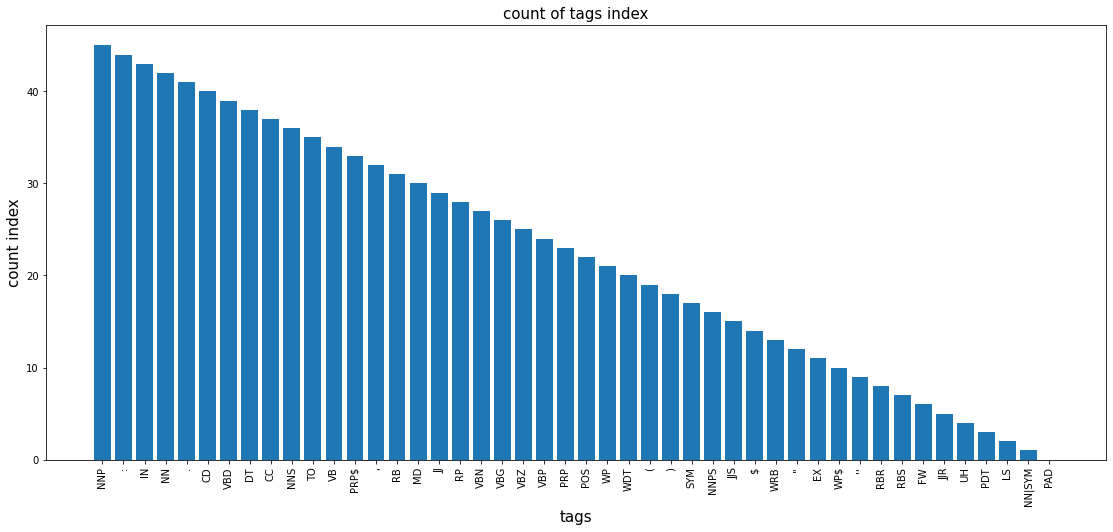

In [35]:
plt.figure(figsize=[19, 8])
plt.bar(tag_index.keys(), sorted(tag_index.values(),reverse = True))

plt.title('count of tags index', fontsize=15)
plt.xlabel('tags', fontsize=15)
plt.ylabel('count index', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_sent = []
train_tag = []
val_sent = []
val_tag = []
test_sent = []
test_tag = []
sentences_corpus = {'test_sent': test_sent, 'test_tag': test_tag, 
                    'val_sent': val_sent, 'val_tag': val_tag, 
                    'train_sent': train_sent, 'train_tag': train_tag}
sent_corpus_list = ['test_sent', 'test_tag', 
                    'train_sent', 'train_tag',
                    'val_sent', 'val_tag']
sentences_corpus

{'test_sent': [],
 'test_tag': [],
 'train_sent': [],
 'train_tag': [],
 'val_sent': [],
 'val_tag': []}

Read all three datasets into a list of lists.

In [ ]:
for i, f in enumerate(data_files):
    sent = []
    tag = []
    for l in open(f):
        if l in ['\n', '\r\n']:
            sentences_corpus[sent_corpus_list[2*i]].append(sent)
            sentences_corpus[sent_corpus_list[2*i+1]].append(tag)
            sent = []
            tag = []
        else:
            t = l.replace('\r\n', '').split()
            sent.append(t[0])
            tag.append(t[1])

In [ ]:
sentences_corpus[sent_corpus_list[2]]

[['SOCCER',
  '-',
  'JAPAN',
  'GET',
  'LUCKY',
  'WIN',
  ',',
  'CHINA',
  'IN',
  'SURPRISE',
  'DEFEAT',
  '.'],
 ['Nadim', 'Ladki'],
 ['AL-AIN', ',', 'United', 'Arab', 'Emirates', '1996-12-06'],
 ['Japan',
  'began',
  'the',
  'defence',
  'of',
  'their',
  'Asian',
  'Cup',
  'title',
  'with',
  'a',
  'lucky',
  '2-1',
  'win',
  'against',
  'Syria',
  'in',
  'a',
  'Group',
  'C',
  'championship',
  'match',
  'on',
  'Friday',
  '.'],
 ['But',
  'China',
  'saw',
  'their',
  'luck',
  'desert',
  'them',
  'in',
  'the',
  'second',
  'match',
  'of',
  'the',
  'group',
  ',',
  'crashing',
  'to',
  'a',
  'surprise',
  '2-0',
  'defeat',
  'to',
  'newcomers',
  'Uzbekistan',
  '.'],
 ['China',
  'controlled',
  'most',
  'of',
  'the',
  'match',
  'and',
  'saw',
  'several',
  'chances',
  'missed',
  'until',
  'the',
  '78th',
  'minute',
  'when',
  'Uzbek',
  'striker',
  'Igor',
  'Shkvyrin',
  'took',
  'advantage',
  'of',
  'a',
  'misdirected',
  'defen

In [ ]:
MAX_LEN = 150
batch_size = 32

Check if GPU is available?

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#n_gpu = torch.cuda.device_count()
device

device(type='cuda')

In [ ]:
!nvidia-smi

Thu Jan 13 20:17:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Load the pretrained English BERT tokenizer model from PyTorch Hub.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]


Tokenize every word into word pieces and clone the tag according to the number of word pieces.

In [ ]:
def tokenize_and_preserve_tags(sentence, sent_tags):
    tokenized_sentence = []
    tags = []
    n_tokens = []

    for w, t in zip(sentence, sent_tags):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(w)
        n_subwords = len(tokenized_word)
        n_tokens.append(n_subwords)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels b`n_subwords` times
        tags.extend([t] * n_subwords)

    return tokenized_sentence, tags, n_tokens

Tokenize the training dataset.

In [ ]:
train_tokenized_sents_and_tags = [
    tokenize_and_preserve_tags(sent, tag)
    for sent, tag in zip(sentences_corpus['train_sent'], sentences_corpus['train_tag'])
]

In [ ]:
print(train_tokenized_sents_and_tags[4])

(['But', 'China', 'saw', 'their', 'luck', 'desert', 'them', 'in', 'the', 'second', 'match', 'of', 'the', 'group', ',', 'crashing', 'to', 'a', 'surprise', '2', '-', '0', 'defeat', 'to', 'newcomer', '##s', 'Uzbekistan', '.'], ['CC', 'NNP', 'VBD', 'PRP$', 'NN', 'VB', 'PRP', 'IN', 'DT', 'NN', 'NN', 'IN', 'DT', 'NN', ',', 'VBG', 'TO', 'DT', 'NN', 'CD', 'CD', 'CD', 'NN', 'TO', 'NNS', 'NNS', 'NNP', '.'], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1])


Split the training dataset into texts, labels and number of tokens of every word.

In [ ]:
train_tokenized_texts = [token_label_pair[0] for token_label_pair in train_tokenized_sents_and_tags]
train_labels = [token_label_pair[1] for token_label_pair in train_tokenized_sents_and_tags]
num_tokens = [token_label_pair[2] for token_label_pair in train_tokenized_sents_and_tags]

In [ ]:
print(train_tokenized_texts[3])
print(train_labels[3])
print(num_tokens[3])

['Japan', 'began', 'the', 'defence', 'of', 'their', 'Asian', 'Cup', 'title', 'with', 'a', 'lucky', '2', '-', '1', 'win', 'against', 'Syria', 'in', 'a', 'Group', 'C', 'championship', 'match', 'on', 'Friday', '.']
['NNP', 'VBD', 'DT', 'NN', 'IN', 'PRP$', 'JJ', 'NNP', 'NN', 'IN', 'DT', 'JJ', 'CD', 'CD', 'CD', 'VBP', 'IN', 'NNP', 'IN', 'DT', 'NNP', 'NNP', 'NN', 'NN', 'IN', 'NNP', '.']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
train_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in train_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
print(train_tokenized_texts[4])
print(train_input_ids[4])
print(train_tags[4])

['But', 'China', 'saw', 'their', 'luck', 'desert', 'them', 'in', 'the', 'second', 'match', 'of', 'the', 'group', ',', 'crashing', 'to', 'a', 'surprise', '2', '-', '0', 'defeat', 'to', 'newcomer', '##s', 'Uzbekistan', '.']
[ 1252  1975  1486  1147  6920  6941  1172  1107  1103  1248  1801  1104
  1103  1372   117 13423  1106   170  3774   123   118   121  3326  1106
 25551  1116 18245   119     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0

Generate masks for every input sequence to mask the inserted PAD(0) tokens.

In [ ]:
train_attention_masks = [[float(i != 0.0) for i in ii] for ii in train_input_ids]
print(train_attention_masks[4])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Load and pre-process the validation dataset.

In [ ]:
val_tokenized_sents_and_tags = [
    tokenize_and_preserve_tags(sent, tag)
    for sent, tag in zip(sentences_corpus['val_sent'], sentences_corpus['val_tag'])
]

In [ ]:
val_tokenized_texts = [token_label_pair[0] for token_label_pair in val_tokenized_sents_and_tags]
val_labels = [token_label_pair[1] for token_label_pair in val_tokenized_sents_and_tags]

In [ ]:
val_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
val_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in val_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
val_attention_masks = [[float(i != 0.0) for i in ii] for ii in val_input_ids]
#print(val_attention_masks[2])

In [ ]:
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
train_tags = torch.tensor(train_tags)
val_tags = torch.tensor(val_tags)
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)

In [ ]:
training_data = TensorDataset(train_inputs, train_masks, train_tags)
training_sampler = RandomSampler(training_data)
training_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

In [ ]:
training_data[4]

(tensor([ 1252,  1975,  1486,  1147,  6920,  6941,  1172,  1107,  1103,  1248,
          1801,  1104,  1103,  1372,   117, 13423,  1106,   170,  3774,   123,
           118,   121,  3326,  1106, 25551,  1116, 18245,   119,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

Load the pretrained English BERT model for token classification from PyTorch Hub

In [ ]:
ner_model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag_index),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
ner_model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(ner_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(ner_model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
epochs = 2
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(training_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
tick1 = time.time()
localtime = time.asctime(time.localtime(time.time()))
print( localtime)

Thu Jan 13 20:18:39 2022


In [ ]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================

    # Set the ner model to training mode.
    ner_model.train()
    total_loss = 0

    # Training loop
    for step, batch in enumerate(training_dataloader):
        # add batch to device (gpu or cpu)
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # reset gradients before performing a backward pass.
        ner_model.zero_grad()
        # forward pass, get the training loss
        outputs = ner_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the training loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        total_loss += loss.item()
        # Clip the norm of the gradient to prevent from the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=ner_model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(training_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================

    # Set the ner model to evaluation mode
    ner_model.eval()
    # Reset the validation loss
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Don't need to compute gradients
        with torch.no_grad():
            # Forward pass, calculate the predicted logits
            outputs = ner_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    
    pred_tags = []
    valid_tags = []
    for p, l in zip(predictions, true_labels):
        preds = []
        labs = []
        for p_i, l_i in zip(p, l):
            if index_tag[l_i] != "PAD":
                preds.append(index_tag[p_i])
                labs.append(index_tag[l_i])
        pred_tags.append(preds)
        valid_tags.append(labs)
    
    print("Validation Precision: {}".format(precision_score(valid_tags, pred_tags)))
    print("Validation Recall: {}".format(recall_score(valid_tags, pred_tags)))
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
    print("Report: {}".format(classification_report(valid_tags, pred_tags)))
    print()

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Average train loss: 1.5167890003433935
Validation loss: 0.6455570863631972


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NNP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VBZ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: JJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

Validation Precision: 0.7809554399792457
Validation Recall: 0.781906899942485
Validation Accuracy: 0.850176465840469
Validation F1-Score: 0.781430880339688


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 1/2 [04:12<04:12, 252.84s/it]

Report:               precision    recall  f1-score   support

           '       0.00      0.00      0.00        35
           B       0.76      0.64      0.69      7429
          BD       0.76      0.89      0.82      8276
          BG       0.84      0.56      0.67      2578
          BN       0.53      0.52      0.52      3850
          BP       0.81      0.17      0.29      1435
          BR       0.00      0.00      0.00       163
          BS       0.00      0.00      0.00        35
          BZ       0.71      0.81      0.76      2416
           C       0.81      0.92      0.86      3650
           D       0.79      0.80      0.79     13630
          DT       0.00      0.00      0.00       539
           H       0.00      0.00      0.00        29
           J       0.55      0.58      0.57     10755
          JR       0.00      0.00      0.00       382
          JS       0.00      0.00      0.00       254
           N       0.77      0.80      0.78     31540
          NP       

Epoch: 100%|██████████| 2/2 [08:30<00:00, 255.02s/it]

Report:               precision    recall  f1-score   support

           '       0.00      0.00      0.00        35
           B       0.76      0.77      0.77      7429
          BD       0.90      0.92      0.91      8276
          BG       0.87      0.75      0.80      2578
          BN       0.73      0.73      0.73      3850
          BP       0.86      0.66      0.75      1435
          BR       0.00      0.00      0.00       163
          BS       0.00      0.00      0.00        35
          BZ       0.87      0.86      0.87      2416
           C       0.95      0.94      0.94      3650
           D       0.86      0.89      0.88     13630
          DT       0.97      0.44      0.60       539
           H       0.00      0.00      0.00        29
           J       0.65      0.67      0.66     10755
          JR       0.00      0.00      0.00       382
          JS       0.00      0.00      0.00       254
           N       0.82      0.84      0.83     31540
          NP       

In [ ]:
localtime = time.asctime(time.localtime(time.time()))
print("l'heure de la fin est：", localtime)

tick2 = time.time()
print("Elapsed time: ", tick2 - tick1)
print(time.strftime("%H:%M:%S", time.localtime(tick2-tick1-3600*8)))

l'heure de la fin est： Thu Jan 13 20:27:13 2022
Elapsed time:  514.2583532333374
16:08:34


In [ ]:
ner_model.train()
torch.save(ner_model, '/content/drive/My Drive/bert_ner.pt')

In [ ]:
#ner_model = torch.load('bert_ner.pt', map_location=torch.device('cpu'))
ner_model = torch.load('/content/drive/My Drive/bert_ner.pt')
ner_model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

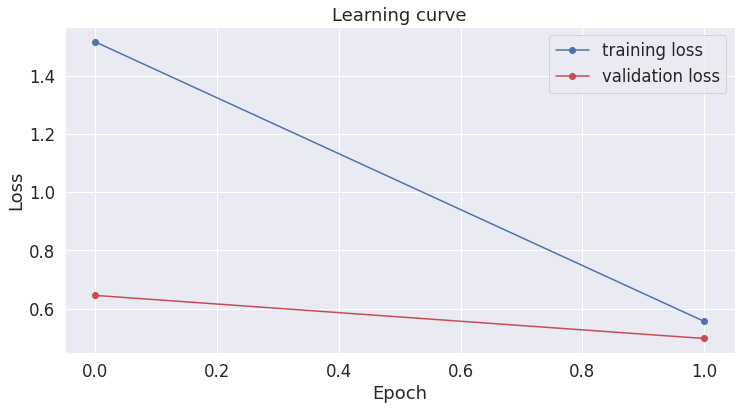

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
test_sentence = """The European Commission said on Thursday it disagreed with German 
advice to consumers to shun British lamb until scientists determine whether mad cow 
disease can be transmitted to sheep."""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
#input_ids = torch.tensor([tokenized_sentence])

with torch.no_grad():
    output = ner_model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(index_tag[label_idx])
        new_tokens.append(token)
        
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

NN	[CLS]
DT	The
NNP	European
NNP	Commission
VBD	said
IN	on
NNP	Thursday
PRP	it
VBD	disagreed
IN	with
NNP	German
NN	advice
TO	to
NNS	consumers
TO	to
VB	shun
JJ	British
NN	lamb
IN	until
NNS	scientists
VB	determine
IN	whether
JJ	mad
NN	cow
NN	disease
VBZ	can
VB	be
VBN	transmitted
TO	to
NN	sheep
NN	.
VB	[SEP]


In [ ]:
test_tokenized_sents_and_tags = [
    tokenize_and_preserve_tags(sent, tag)
    for sent, tag in zip(sentences_corpus['test_sent'], sentences_corpus['test_tag'])
]

In [ ]:
test_tokenized_texts = [token_label_pair[0] for token_label_pair in test_tokenized_sents_and_tags]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_sents_and_tags]
num_tokens = [token_label_pair[2] for token_label_pair in test_tokenized_sents_and_tags]

In [ ]:
test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
test_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]
#print(test_attention_masks[3])

In [ ]:
test_inputs = torch.tensor(test_input_ids)
test_tags = torch.tensor(test_tags)
test_masks = torch.tensor(test_attention_masks)

In [ ]:
test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
%%time

test_pred_tags, test_predictions = [], []
test_true_labels, test_token_ids, test_input_tokens = [], [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Forward pass, calculate the predicted logits
        outputs = ner_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)#, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    token_ids = b_input_ids.to('cpu').numpy()
    
    test_predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    test_true_labels.extend(label_ids)
    test_token_ids.extend(token_ids)
    
for p, l in zip(test_predictions, test_true_labels):
    preds = []
    labs = []
    for p_i, l_i in zip(p, l):
        if index_tag[l_i] != "PAD":
            preds.append(index_tag[p_i])                
    test_pred_tags.append(preds)
    
for ids in test_token_ids:
    token = []
    for t in ids:
        if t != 0:
            token.append(t)    
    test_input_tokens.append(tokenizer.convert_ids_to_tokens(token))

CPU times: user 36.3 s, sys: 92.1 ms, total: 36.4 s
Wall time: 36.2 s


In [ ]:
new_tokens, new_tags = [], []
for tokens, tags in zip(test_input_tokens, test_pred_tags):
    new_tok, new_t = [], []
    for t, tag in zip(tokens, tags):
        if t.startswith("##"):
            new_tok[-1] = new_tok[-1] + t[2:]
        else:
            new_t.append(tag)
            new_tok.append(t)
    new_tokens.append(new_tok)
    new_tags.append(new_t)

In [ ]:
pred_tags = []
for i in test_pred_tags:
    pred_tags.extend(i)
#pred_tags

In [ ]:
n_token = []
for i in num_tokens:
    n_token.extend(i)
#n_token

Save the predicted named entities to test-submit.txt

In [ ]:
%%time

submit = '/content/drive/My Drive/test-submit.txt'
test = '/content/drive/My Drive/data/test.txt'
fid2 = open(submit, 'w', encoding='UTF-8')
i = 0
j = 0
with codecs.open(test, encoding='utf-8') as fid:
    for l in fid:
        if l == '\r\n' or l == '\n': 
            print(l, end='')
            fid2.write(l)
        else:
            l = l.replace('\r\n', '')
            line = l.rstrip()[:-1]+pred_tags[i]+'\n'
            i = i + n_token[j]
            j = j + 1
            print(line, end='')
            fid2.write(line)
fid2.close()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
22 CD I-NP NN
8 CD I-NP VBD
6 CD I-NP IN
8 CD I-NP DT
27 CD I-NP NN
21 CD I-NP IN
30 CD B-NP NNP

Stoke VB B-VP B-ORJJ
20 CD B-NP IN
8 CD I-NP NNP
6 CD I-NP ,
6 CD I-NP JJ
27 CD I-NP NN
30 CD B-NP VBD
30 CD I-NP IN

Swindon NN B-NP B-ORNNP
22 CD I-NP .
9 CD I-NP DT
2 CD I-NP NN
11 CD I-NP ,
32 CD I-NP VBN
28 CD I-NP IN
29 CD I-NP DT

Charlton NNP B-NP B-ORNNP
21 CD I-NP NNP
9 CD I-NP NNP
2 CD I-NP (
10 CD I-NP NNP
23 CD I-NP )
29 CD I-NP ,
29 CD I-NP VBD

Huddersfield VBN B-VP B-ORNN
22 CD B-NP NNS
7 CD I-NP IN
7 CD I-NP VBG
8 CD I-NP CD
25 CD I-NP JJ
28 CD I-NP NNS
28 CD I-NP VBD

Queens NNP B-NP B-ORVBN
Park NNP I-NP I-ORIN
Rangers NNPS I-NP I-ORDT
22 CD I-NP NN
7 CD I-NP IN
7 CD I-NP DT
8 CD I-NP NN
25 CD I-NP IN
28 CD I-NP NNP
28 CD I-NP .

Port NNP B-NP B-ORDT
Vale NNP I-NP I-ORVBN
22 CD I-NP CD
6 CD I-NP NNS
10 CD I-NP VBD
6 CD I-NP VBN
19 CD I-NP VBN
22 CD I-NP IN
28 CD I-NP JJ

Ipswich NNP B-NP B-ORNN